In [37]:
import pandas as pd
from pandas import ExcelWriter
%matplotlib inline

In [38]:
from datetime import datetime 
import time 

btc_df = pd.read_csv('../data/BTC/BTC_2012-2018_1min.csv')
btc_df["Date"] = pd.to_datetime(btc_df["Timestamp"], unit='s')

google_trends_df = pd.read_csv('C:/Users/Shoya/surf/data/Google_Trends_pt1.csv', encoding='latin1')
google_trends_df["date"] = pd.to_datetime(google_trends_df["date"])
google_trends_df["Timestamp"] = [time.mktime(t.timetuple()) for t in google_trends_df.date]
#there's probably some regional time error here (look few cells down)


display(btc_df.head())
display(btc_df.tail())
display(google_trends_df.head())
display(google_trends_df.tail())

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:52:00
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:53:00
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:54:00
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:55:00
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:56:00


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
3273372,1522108560,8159.21,8159.39,8153.62,8153.68,0.663192,5408.215377,8154.826880,2018-03-26 23:56:00
3273373,1522108620,8159.38,8163.72,8152.81,8155.00,3.720024,30333.753144,8154.182788,2018-03-26 23:57:00
3273374,1522108680,8157.47,8158.60,8130.01,8130.01,27.294436,222388.761970,8147.769162,2018-03-26 23:58:00
3273375,1522108740,8145.17,8149.66,8130.01,8149.66,23.065281,187570.784940,8132.169837,2018-03-26 23:59:00
3273376,1522108800,8152.26,8164.68,8151.37,8153.04,17.758130,144820.147410,8155.146220,2018-03-27 00:00:00


,date,Bitcoin,Ethereum,Ripple,Buy Bitcoin,Coinbase,isPartial,Timestamp
0,2015-01-06 00:00:00,79,1,11,2,2,False,1.420520e+09
1,2015-01-06 01:00:00,63,1,11,2,2,False,1.420524e+09
2,2015-01-06 02:00:00,67,1,14,2,2,False,1.420528e+09
3,2015-01-06 03:00:00,57,0,11,1,1,False,1.420531e+09
4,2015-01-06 04:00:00,56,1,9,2,2,False,1.420535e+09


,date,Bitcoin,Ethereum,Ripple,Buy Bitcoin,Coinbase,isPartial,Timestamp
33595,2018-05-22 19:00:00,82,11,12,2,6,False,1.527030e+09
33596,2018-05-22 20:00:00,86,12,12,2,7,False,1.527034e+09
33597,2018-05-22 21:00:00,96,13,14,2,7,False,1.527037e+09
33598,2018-05-22 22:00:00,96,13,14,2,7,False,1.527041e+09
33599,2018-05-22 23:00:00,96,12,13,2,7,False,1.527044e+09


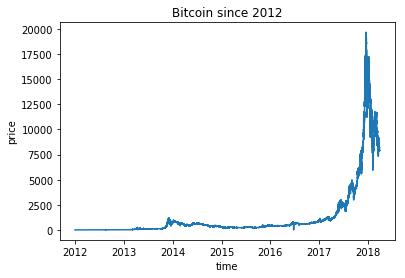

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(btc_df["Date"], btc_df["Close"])
ax.set_title("Bitcoin since 2012")
ax.set(ylabel="price",xlabel="time")
plt.show()

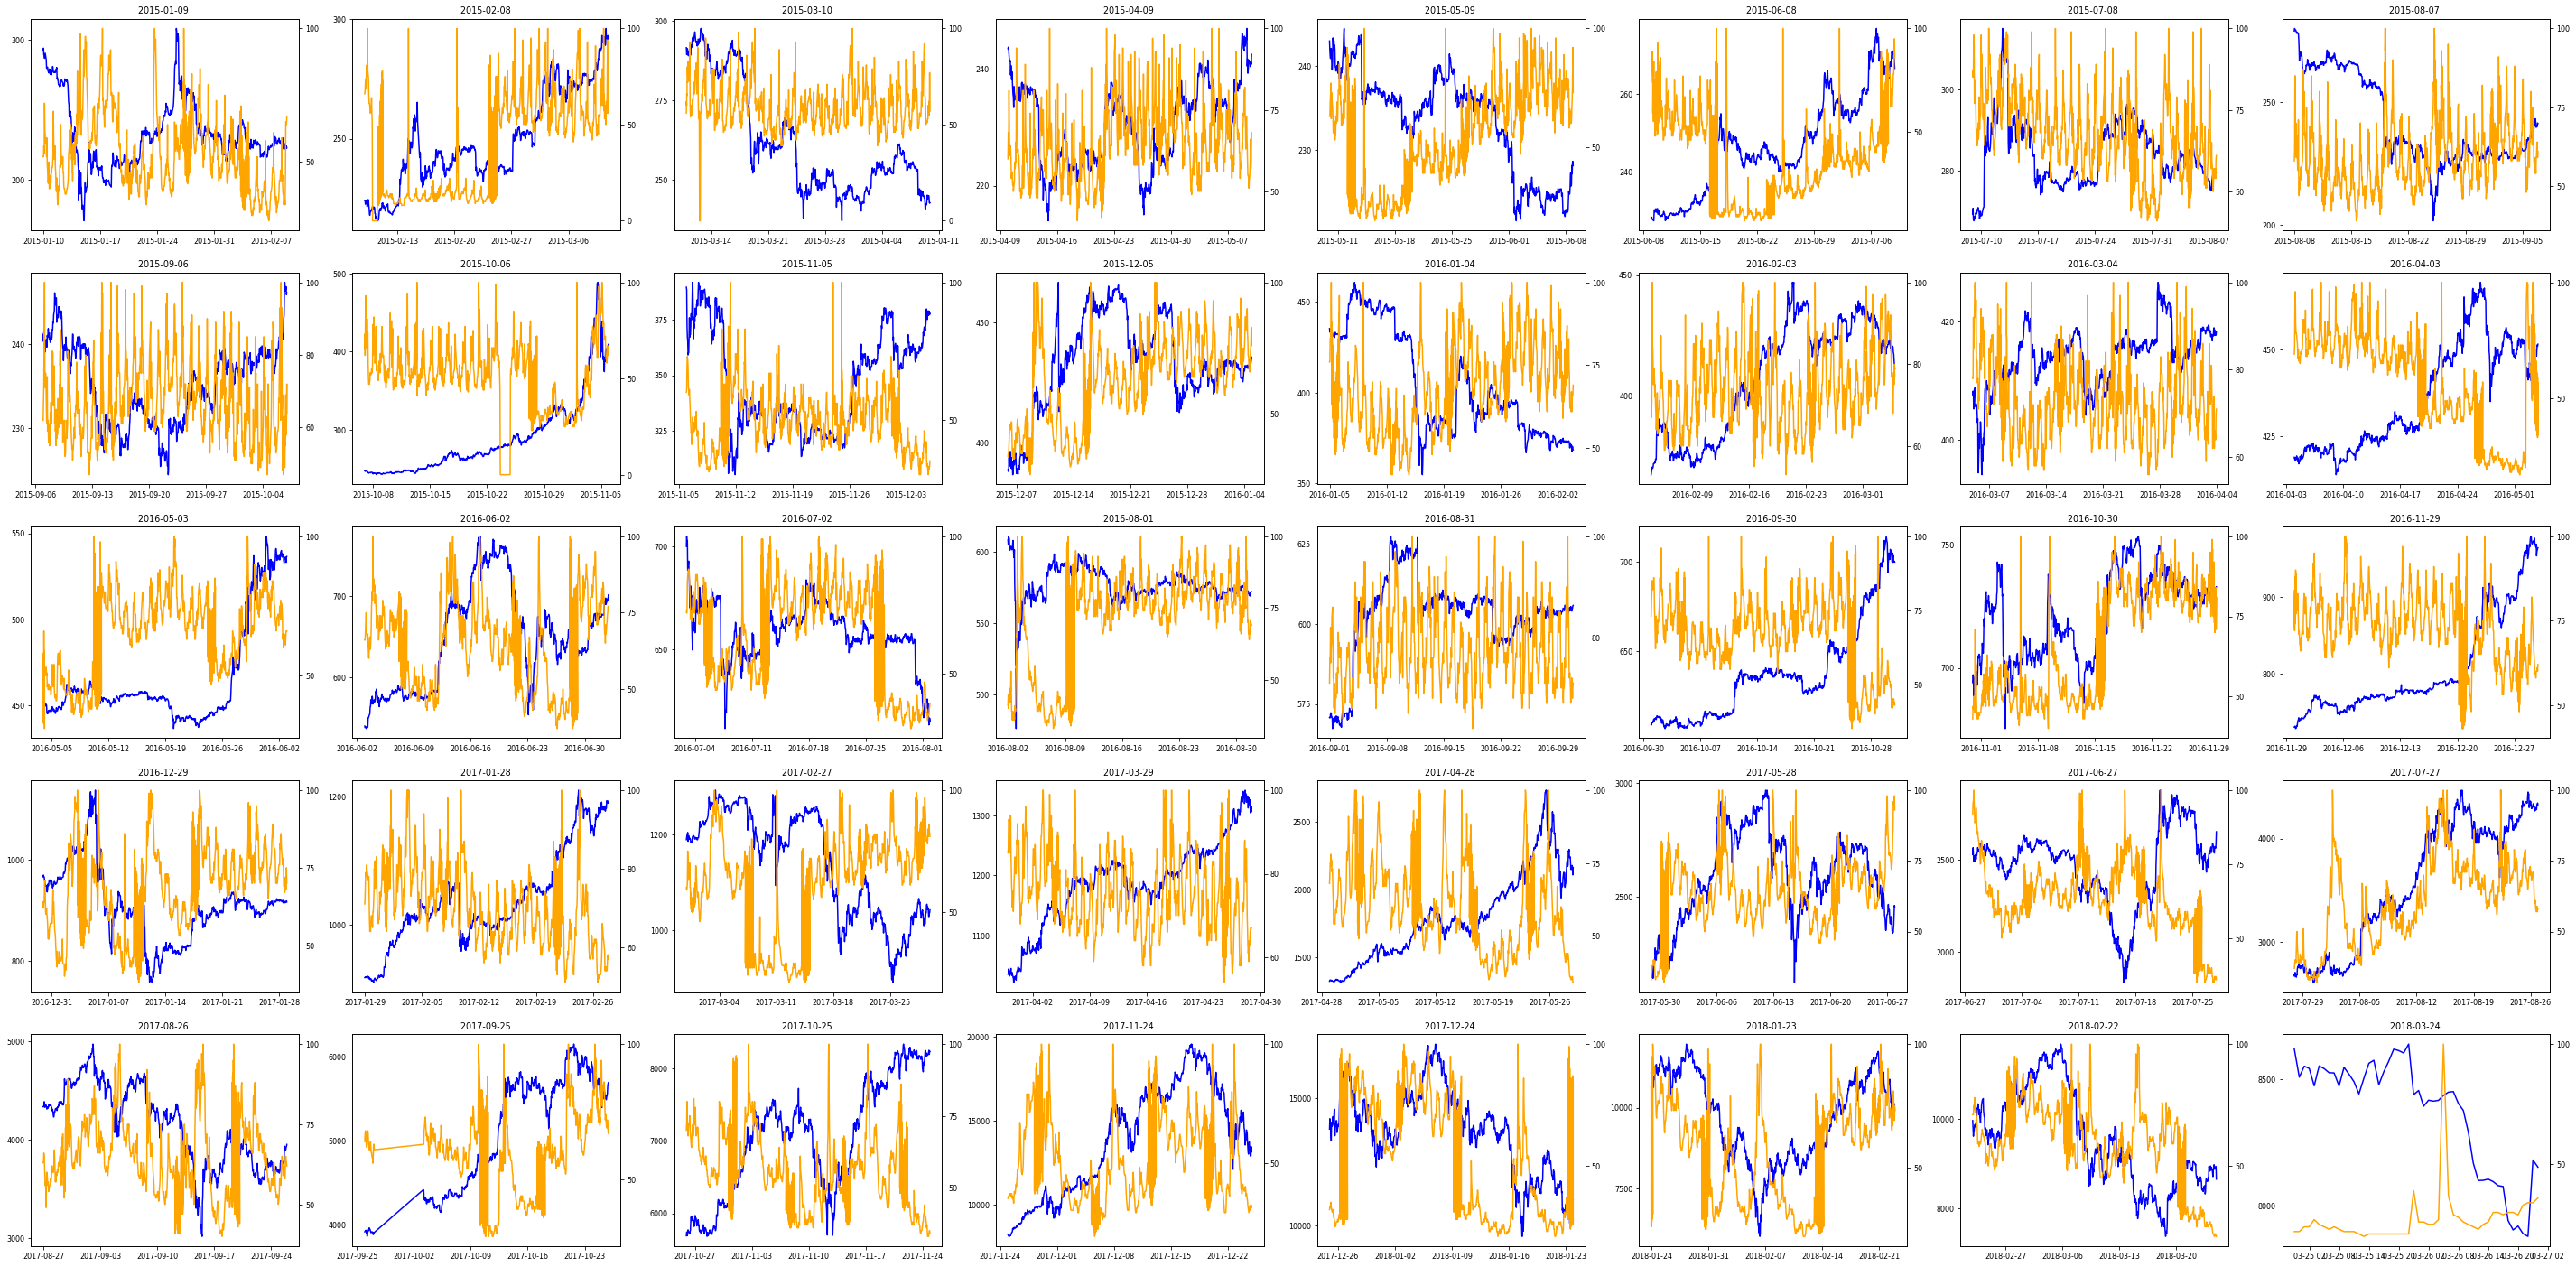

In [43]:
from sklearn import preprocessing

btc_and_trends_df_hourly = pd.merge(left=btc_df, left_on="Timestamp", right=google_trends_df, right_on="Timestamp")
min_max_scaler=preprocessing.MinMaxScaler()
#change so that it just creates a new column

# btc_and_trends_df_hourly[['close_normalized','bitcoin_normalized']] = btc_and_trends_df_hourly[['Close','Bitcoin']]

# btc_and_trends_df_hourly[['close_normalized','bitcoin_normalized']] = min_max_scaler.fit_transform(btc_and_trends_df_hourly[['close_normalized','bitcoin_normalized']])
# btc_and_trends_df_hourly.head()

# fig, ax = plt.subplots()
# ax.plot(btc_and_trends_df_hourly["Date"], btc_and_trends_df_hourly["close_normalized"])
# ax.plot(btc_and_trends_df_hourly["Date"], btc_and_trends_df_hourly["bitcoin_normalized"])
# ax.set_title("Bitcoin Close Prices and Google Trends Normalized")
# ax.set(ylabel="price and trend, scaled to 0-1",xlabel="time")
# plt.show()

fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(50,25), sharex=False, sharey=False)

start_timestamp = btc_and_trends_df_hourly["Timestamp"][0] 
end_timestamp = btc_and_trends_df_hourly["Timestamp"].iloc[-1] 

for i, ax in enumerate(axes.flatten()):
    in_range_df = btc_and_trends_df_hourly[ (btc_and_trends_df_hourly["Timestamp"] > start_timestamp) & (btc_and_trends_df_hourly["Timestamp"] <= start_timestamp+2592000) ]
    ax.plot(in_range_df["Date"], in_range_df["Close"], color='blue')
    ax2 = ax.twinx() 
    ax2.plot(in_range_df["Date"], in_range_df["Bitcoin"], color='orange' )
    ax.set_title(str(in_range_df["Date"].iloc[0])[:-8])
    start_timestamp += 2592000
    
plt.rcParams.update({'font.size': 30})
plt.show()
